<a href="https://colab.research.google.com/github/denocris/NLP-Workshop-MLMilan/blob/master/part1_wordsensedisamb_ita_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Sense Disambiguation and Embedding Visualization with an Italian RoBERTa


### Slides
To follow the notebook [these slides](https://docs.google.com/presentation/d/e/2PACX-1vQSCVJkfs5toV9UkFGx0JnEw6u9KJWe0HlwrooZ7I4FSbVF4LdAOhKjFrrjyHxDc1EflqMmGnvvo1-r/pub?start=false&loop=false&delayms=3000) might be useful. 

### My Contacts
For any questions or doubts you can find my contacts here:

* [Linkedin](https://www.linkedin.com/in/cristiano-de-nobili/) and [Twitter](https://twitter.com/denocris) (here I post about AI and Science)
* My recent TEDx on [AI and Human Creativity](https://youtu.be/8-hrmer9d_E)
* My [Personal Website](https://denocris.com)
* My [Instagram](https://www.instagram.com/denocris/?hl=it) (I am a Pilot, so here I mostly post about my adventures)

---






### Introduction

#### What is BERT ?

[BERT](https://arxiv.org/abs/1810.04805) (Bidirectional Encoder Representations from Transformers) is a [transformer-based architecture](https://arxiv.org/abs/1706.03762). More precisely, it is a stack of **transformer** encoder layers that consist of multiple heads, i.e. fully connected neural networks augmented with a self-attention mechanism. 

**Self-attention** is a non-local operator, which means that at any layer a token can attend to all other tokens regardless of their distance. Self-attention thus produces so-called contextual word embeddings, as successive layers gradually aggregate contextual information into the embedding of the input word.

<center>  <img src="https://drive.google.com/uc?id=1fdBEGUc4mfXTbyaUVnTEZQa6Zwj0ZTnT" width="650" height="400">  </center> 

The input to BERT is based on a sequence of tokens (words or pieces of words). The output is a sequence of vectors, one for each input token. We will often refer to these vectors as context embeddings because they include information about a token’s context. 

The conventional workflow for BERT consists of two stages: **pre-training** and **fine-tuning** for downstream applications. In this notebook, we will deal with fine-tuning. In fine-tuning, one or more layers are typically added on top of the pre-trained BERT. The whole algorithm will then be fine-tuned on some data.

#### What will we do?

In our specific case, we will use [RoBERTa](https://arxiv.org/abs/1907.11692). It is a variant of of BERT which "modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates".

In particular, we will start from an Italian pre-trained RoBERTA (Gilberto and Umberto) and fine-tune it to a classification downstream task. In particular, as a simple example, we `will disambiguate a polysemic Italian word`.

How it is possible disambiguation? BERT generates contextual embeddings. 

Experiments suggest context embeddings in BERT and related models contain enough information to perform many tasks in the traditional NLP pipeline. In particular, the authors of [this paper](https://arxiv.org/abs/1906.02715), explore the geometry of internal representations of BERT and claim that its contextual embeddings contains information about syntactics and semantics of a word. In particular, turning to semantics, using visualizations of the activations created by different pieces of text, they show suggestive evidence that BERT distinguishes word senses at a very ﬁne level.


Actually, here we will work with RoBERTa (which is a slight modification of the original BERT in particular in the way of training) and following the procedure explained in the above paper we will at the end visualize word embeddings.

---

### Disclaimer

*   This notebook (and the whole workshop) is a bit advanced. The aim is not to let you understand all the details. We do not have time. The aim is to just let you aware of these powerful tools and have a taste of them. For any additional curiosity feel free to ask.
*   We will not be mathematically precise about the geometry of BERT embeddings. They have been recently discovered and many studies are on going. Some interesting papers: [one](https://nlp.stanford.edu/pubs/hewitt2019structural.pdf), [two](https://arxiv.org/abs/1906.02715), [three](https://arxiv.org/abs/1909.00512), [four](https://arxiv.org/abs/2002.12327).

---

### Tools Used

* [PyTorch](https://pytorch.org/) as deep learning framework
* [HuggingFace Transformers](https://huggingface.co/transformers/) library as NLP tool kit
* [Italian Gilberto](https://github.com/idb-ita/GilBERTo) pre-trained RoBERTa by Giulio Ravasio and Leonardo Di Perna.
* [Italian Umberto](https://github.com/musixmatchresearch/umberto) pre-trained RoBERTa by Simone Francia, Loreto Parisi, Paolo Magnani (Musixmatch).



## Packages

In [0]:
!pip install -q transformers

In [0]:
import tensorflow as tf
import torch
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import random
import copy 
import sys

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import Dataset
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, AutoTokenizer, DistilBertTokenizer
from transformers import BertModel, AutoModel, DistilBertModel
import torch.nn as nn

Using TensorFlow backend.


Check GPU Settings

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu May 21 08:59:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


## Download Data

For lack of time, we omit data preprocessing and just dowload some ready-to-use data

In [0]:
# Download Training Set
!gdown --id 1cYJCe2eIqDLZWPzWxpjcVU4AQbmunQvQ
# Download Validation Set
!gdown --id 1aL7uZ5FEdWjUe4hqZD9kzJgC8-IWd-0-
# Download Test Set
!gdown --id 1Q1AGMgUD3XH89G2XLODmBOJ6ybZyyjFk
# Mkdir Model
!mkdir Models

Downloading...
From: https://drive.google.com/uc?id=1cYJCe2eIqDLZWPzWxpjcVU4AQbmunQvQ
To: /content/train_sei.tsv
100% 1.84M/1.84M [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aL7uZ5FEdWjUe4hqZD9kzJgC8-IWd-0-
To: /content/valid_sei.tsv
100% 393k/393k [00:00<00:00, 55.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q1AGMgUD3XH89G2XLODmBOJ6ybZyyjFk
To: /content/test_sei.tsv
100% 70.1k/70.1k [00:00<00:00, 25.6MB/s]


In [0]:
! wc -l *_sei.tsv

   1500 test_sei.tsv
  40000 train_sei.tsv
   8500 valid_sei.tsv
  50000 total


In [0]:
! head -n 10 train_sei.tsv
# label 1: sei VERB
# label 0: sei NUMBER

dove sei stato e cosa hai fatto	1
sei ancora suo collega in azienda vedo	1
i due ebbero sei figli e undici nipoti	0
non sei andata in francia l altra settimana	1
non sai nemmeno quando ti sei ferito	1
stai cercando lavoro da sei mesi circa	0
tu sei ancora a milano o sei partito	1
so che sei un bugiardo larry	1
tu sei il portatore dell anello frodo	1
ti sei buttato a capofitto nel pericolo e hai portato doyle in salvo	1


As you can see, our dataset is made of two type of sentences (labelled differently): sentences where the word `sei` is a VERB and sentences where sei is a NUMBER. The dataset was built scraping different sources from the web. Only sentences shorter than a fixed length were filtered.





### Data Loader

Before giving any inputs to a BERT-like model, it is important to prepare the sentence the way BERT likes to ingest it. In more technical words, we must tokenize properly our input. A tokenizer is in charge of preparing the inputs for a model. We will use pre-trained tokenizer, but it is worth knowing that you can train your own tokenizer.

In [0]:
class SSTDataset(Dataset):

    def __init__(self, filename, maxlen, bert_type = 'ita-gilberto'):

        #Store the contents of the file in a pandas dataframe
        self.df = pd.read_csv(filename, delimiter = '\t', header=None)
        self.maxlen = maxlen

        #Initialize the BERT tokenizer
        if bert_type == 'ita-gilberto':
            # Italian BERT (GilBERTo)
            self.tokenizer = AutoTokenizer.from_pretrained("idb-ita/gilberto-uncased-from-camembert", do_lower_case=True)
        elif bert_type == 'ita-umberto':
            # Italian BERT (UmBERTo)
            self.tokenizer = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", do_lower_case=True)
        elif bert_type == 'multilingual':
            # Multilingual
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
        elif bert_type == 'distil-multilingual': 
            # Distilled Multilingual
            self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased', do_lower_case=True)

        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 0]
        label = self.df.loc[index, 1]

        # tokenize the sentence
        try:
            encoded_sent = self.tokenizer.encode(sentence, add_special_tokens = True)
        except:
            print("---- CHECK THIS SENTENCE ----- >>", sentence, label)
            sys.exit()

        # padding the sentence to the max length
        if len(encoded_sent) > self.maxlen:
            encoded_sent = encoded_sent[:self.maxlen - 2]
        padded_sent  = encoded_sent + [0 for _ in range(self.maxlen - len(encoded_sent))]
        #Converting the list to a pytorch tensor
        tokens_ids_tensor = torch.tensor(padded_sent) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

Let us unroll the funcrion and see it step-by-step

In [0]:
# Choose a tokenizer, let's say Gilberto
tokenizer = AutoTokenizer.from_pretrained("idb-ita/gilberto-uncased-from-camembert", do_lower_case=True)

#Choose a sentence
sentence = 'Ciao come stai? Cosa fai stasera?'

# Tokenize with special tokens (<s> and <\s> for RoBERTa)
encoded_sent = tokenizer.encode(sentence, add_special_tokens = True)
tokens_from_ids = tokenizer.convert_ids_to_tokens(encoded_sent)
padded_sent  = encoded_sent + [0 for _ in range(20 - len(encoded_sent))]
tokens_ids_tensor = torch.tensor(padded_sent)
attn_mask = (tokens_ids_tensor != 0).long()

print('\n', encoded_sent)
print('\n', tokens_from_ids)
print('\n', padded_sent)
print('\n', tokens_ids_tensor)
print('\n', attn_mask)





 [5, 3171, 198, 5140, 31978, 664, 3291, 10279, 31978, 6]

 ['<s>', '▁ciao', '▁come', '▁stai', '?', '▁cosa', '▁fai', '▁stasera', '?', '</s>']

 [5, 3171, 198, 5140, 31978, 664, 3291, 10279, 31978, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 tensor([    5,  3171,   198,  5140, 31978,   664,  3291, 10279, 31978,     6,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [0]:
MAXLEN= 50
bert_type = 'ita-gilberto' #'ita-umberto'
BATCH_SIZE = 8
MAX_EPS = 5

#Creating dataloaders
train_set = SSTDataset(filename = './train_sei.tsv', maxlen = MAXLEN, bert_type = bert_type)
val_set = SSTDataset(filename = './valid_sei.tsv', maxlen = MAXLEN, bert_type = bert_type)

# Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE , num_workers = 2)
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE , num_workers = 2)

## Model Definition and Training




### Models Definition

Let's define here the simplest BERT model possible: BERT with a classification head

In [0]:
class Net(nn.Module):
    # -------------------------
    # Italian pre-trained Model with a binary classification head.
    # -------------------------
    def __init__(self, freeze_bert = True, bert_type = 'ita-gilberto'):
        super(Net, self).__init__()
        #Instantiating BERT model object
        self.bert_type = bert_type 
        if bert_type == 'ita-gilberto':
            # Italian BERT (GilBERTo)
            self.bert_layer = AutoModel.from_pretrained("idb-ita/gilberto-uncased-from-camembert")
        elif bert_type == 'ita-umberto':
            # Italian BERT (UmBERTo)
            self.bert_layer = AutoModel.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1")
        elif bert_type == 'multilingual':
            # Multilingual
            self.bert_layer = BertModel.from_pretrained('bert-base-multilingual-cased')
        elif bert_type == 'distil-multilingual': 
          # Distilled Multilingual
          self.bert_layer = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

        #Freeze bert layers
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        #Classification layer
        self.dropout = nn.Dropout(p=0.2, inplace=False)
        self.cls_layer = nn.Linear(768, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [batch_size, max_length] containing token ids of sequences
            -attn_masks : Tensor of shape [batch_size, max_length] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        if self.bert_type == 'distil-multilingual':
          cont_reps = self.bert_layer(seq, attention_mask = attn_masks)
          cont_reps = cont_reps[0]
        else: 
          cont_reps, _ = self.bert_layer(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        dropout = self.dropout(cls_rep)
        logits = self.cls_layer(dropout)

        return logits

Let's define train and evaluation steps

In [0]:
def get_accuracy_from_logits(logits, labels):
    softmax = nn.Softmax(dim=1)
    argmax = torch.argmax(softmax(logits.float()), dim=1)
    pred_class = argmax.long()
    acc = (pred_class == labels.long()).float().mean()
    return acc

def evaluate(net, criterion, dataloader):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for seq, attn_masks, labels in dataloader:
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(seq, attn_masks)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

def train(net, criterion, opti, train_loader, val_loader):
    step = 0
    best_acc = 0
    for ep in range(MAX_EPS):
        net.train()
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            step +=1
            #Clear gradients
            opti.zero_grad()
            #Converting these to cuda tensors
            seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()

            #Obtaining the logits from the model
            logits = net(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels.float())
            # For multiclass case, when criterion = nn.CrossEntropyLoss()
            # loss = loss = criterion(logits.squeeze(-1), labels.long())


            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()

            if step % 100 == 0:
                acc = get_accuracy_from_logits(logits, labels)
                print("Iteration {} of epoch {} complete. Loss : {} Accuracy : {}".format(step, ep, loss.item(), acc))
                steps.append(step)
                loss_train.append(loss.item())


        val_acc, val_loss = evaluate(net, criterion, val_loader)
        print("Epoch {} complete! Validation Accuracy : {}, Validation Loss : {}".format(ep, val_acc, val_loss))
        steps_valid.append(step)
        loss_valid.append(val_loss)
        if val_acc > best_acc:
            print("Best validation accuracy improved from {} to {}, saving model...".format(best_acc, val_acc))
            best_acc = val_acc
            #torch.save(net.state_dict(), 'Models/RCNNUmberto-bi-ita_{}_rnn32f100_lr3m7.pt'.format(ep))
            torch.save(net.state_dict(), 'Models/{}_fine-tuned_{}.pt'.format(bert_type, ep))

### Training

In [0]:
SEED = 172

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


net = Net(freeze_bert = False, bert_type = 'ita-gilberto')

#Enable gpu support for the model
net.cuda() 


criterion = nn.BCEWithLogitsLoss()
opti = torch.optim.Adam(net.parameters(), lr = 0.000005)


steps, steps_valid = [], []
loss_train, loss_valid = [], []
train(net, criterion, opti, train_loader, val_loader)

print(loss_train)
plt.figure(figsize=(15, 12))
plt.plot(steps, loss_train, c = 'b')
plt.plot(steps_valid, loss_valid, c = 'g')
plt.savefig('./foo.png')
plt.show()

Save the model on your drive

In [0]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp -r ./Models/ ./drive/My\ Drive/tmp_stuff/BERTCheckpoints/Models/

## Before Inference: Model Loading

The task is the disambiguation of the word `sei` which has at least two meanings: verb and number

In [0]:
#Download Checkpoint already Trained

# Italian pre-trained Gilberto Model with a binary classification head, finetuned on SEI disambiguation.
!gdown --id 18YMFrh3CIWzcL7HAPLQkaXKR7HPBVhgd

# Italian pre-trained Umberto Model with a binary classification head, finetuned on SEI disambiguation.
!gdown --id 1-44hscILUBFMHseoflGyBt9w2QWYTkvp

Downloading...
From: https://drive.google.com/uc?id=18YMFrh3CIWzcL7HAPLQkaXKR7HPBVhgd
To: /content/gilberto_finetuned_sei.pt
443MB [00:07, 62.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-44hscILUBFMHseoflGyBt9w2QWYTkvp
To: /content/umberto_finetuned_sei.pt
443MB [00:06, 68.3MB/s]


In [0]:
# Move checkpoint to Models
!mkdir Models
!mv *_sei.pt ./Models/

mkdir: cannot create directory ‘Models’: File exists


In [0]:
bert_type = 'ita-umberto'
#bert_type = 'ita-gilberto'

In [0]:
class Net(nn.Module):
    # -------------------------
    # Italian pre-trained Model (No fine-tuning applied)
    # -------------------------
    def __init__(self, freeze_bert = False, bert_type = 'ita-gilberto'):
        super(Net, self).__init__()
        #Instantiating BERT model object
        if bert_type == 'ita-gilberto':
            # Italian BERT (GilBERTo)
            self.bert_layer = AutoModel.from_pretrained("idb-ita/gilberto-uncased-from-camembert")
        elif bert_type == 'ita-umberto':
            # Italian BERT (UmBERTo)
            self.bert_layer = AutoModel.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1")
        elif bert_type == 'multilingual':
            # Multilingual
            self.bert_layer = BertModel.from_pretrained('bert-base-multilingual-cased')
        elif bert_type == 'distil-multilingual': 
          # Distilled Multilingual
          self.bert_layer = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

        #Freeze bert layers
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False


    def forward(self, seq, attn_masks):
        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps, _ = self.bert_layer(seq, attention_mask = attn_masks)

        return _, cont_reps


class FineTunedNet(nn.Module):
      # -------------------------
      # Italian pre-trained Model with a binary classification head.
      # -------------------------
    def __init__(self, freeze_bert = False, bert_type = 'ita-gilberto'):
        super(FineTunedNet, self).__init__()
        #Instantiating BERT model object
        self.bert_type = bert_type 
        if bert_type == 'ita-gilberto':
            # Italian BERT (GilBERTo)
            self.bert_layer = AutoModel.from_pretrained("idb-ita/gilberto-uncased-from-camembert")
        elif bert_type == 'ita-umberto':
            # Italian BERT (UmBERTo)
            self.bert_layer = AutoModel.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1")
        elif bert_type == 'multilingual':
            # Multilingual
            self.bert_layer = BertModel.from_pretrained('bert-base-multilingual-cased')
        elif bert_type == 'distil-multilingual': 
          # Distilled Multilingual
          self.bert_layer = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

        #Freeze bert layers
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        #Classification layer
        self.dropout = nn.Dropout(p=0.2, inplace=False)
        self.cls_layer = nn.Linear(768, 1)

    def forward(self, seq, attn_masks):

        #Feeding the input to BERT model to obtain contextualized representations
        if self.bert_type == 'distil-multilingual':
          cont_reps = self.bert_layer(seq, attention_mask = attn_masks)
          cont_reps = cont_reps[0]
        else: 
          cont_reps, _ = self.bert_layer(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        dropout = self.dropout(cls_rep)
        logits = self.cls_layer(dropout)

        return logits, cont_reps

In [0]:
# Load the pre-trained model not finetuned (for visualization purposes in the last section)

net = Net(bert_type = bert_type)
net.eval()

Net(
  (bert_layer): CamembertModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elem

In [0]:
#Load the model with the checkpoint (pre-trained+classification layer. All finetuned on our dataset "sei vs 6")

fineTunedNet = FineTunedNet(bert_type = bert_type)

if bert_type == 'ita-gilberto':
  fineTunedNet.load_state_dict(torch.load('./Models/gilberto_finetuned_sei.pt'))
elif bert_type == 'ita-umberto':
  fineTunedNet.load_state_dict(torch.load('./Models/umberto_finetuned_sei.pt'))

fineTunedNet.eval()

FineTunedNet(
  (bert_layer): CamembertModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Inference and Embedding Visualization

Below we define a couple of useful functions. The first one, given a sentence, will predict its class. The second one will extract embeddings. If the arg `specific_token = ciao` it will extract the embedding of the token `ciao`. If specific_token = `<s>`, it will extract the classification special token ([CLS] for BERT, \<s\> for Roberta). If `specific_token = None`, it will extract an average of all token embeddings (except the special token ones that are removed).

In [0]:
tokenizer_gil = AutoTokenizer.from_pretrained("idb-ita/gilberto-uncased-from-camembert", do_lower_case=True)
tokenizer_umb = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1", do_lower_case=True)

In [0]:
MAX_LEN=50
model_finetuned = fineTunedNet
tokenizer = tokenizer_gil if bert_type == 'ita-gilberto' else tokenizer_umb

In [0]:
def model_inference(model, single_sentence, tokenizer, PRINT=False):
    # tokenize properly the sentence
    encoded_sent = tokenizer.encode(single_sentence, add_special_tokens = True)
    tokens_from_ids = tokenizer.convert_ids_to_tokens(encoded_sent)
    if PRINT: print(tokens_from_ids)
    tokens_length = len(encoded_sent)
    if PRINT: print(encoded_sent)
    # apply padding
    padded_sent  = encoded_sent + [0 for _ in range(MAX_LEN - len(encoded_sent))]
    if PRINT: print(padded_sent)
    # apply mask
    attention_masks = [float(i>0) for i in padded_sent]
    if PRINT: print(attention_masks)
    # convert to tensors
    inputs = torch.tensor([padded_sent])
    masks = torch.tensor([attention_masks])
    # BertModel
    model.eval()
    with torch.no_grad():
      logits, _ = model(inputs, masks)
    
    #logits = logits.detach().cpu()
    probs = torch.sigmoid(logits.unsqueeze(-1))
    return probs

def embedding_extractor(model, single_sentence, tokenizer, specific_token=None, PRINT=True):
    # tokenize properly the sentence
    encoded_sent = tokenizer.encode(single_sentence, add_special_tokens = True)
    tokens_from_ids = tokenizer.convert_ids_to_tokens(encoded_sent)
    if PRINT: print(tokens_from_ids)
    tokens_length = len(encoded_sent)
    if PRINT: print(encoded_sent)
    # apply padding
    padded_sent  = encoded_sent + [0 for _ in range(MAX_LEN - len(encoded_sent))]
    if PRINT: print(padded_sent)
    # apply mask
    attention_masks = [float(i>0) for i in padded_sent]
    if PRINT: print(attention_masks)
    # convert to tensors
    inputs = torch.tensor([padded_sent])
    masks = torch.tensor([attention_masks])
    # BertModel
    model.eval()
    with torch.no_grad():

      _, last_hidden_states  = model(inputs, masks)
    # ---------- all tokens extractor -------------
    last_hidden_states_tokens = last_hidden_states[0][0:tokens_length]
    #token_and_emb = zip(tokens_from_ids,last_hidden_states_tokens)
    # ---------- specific token extractor -------------
    if specific_token is not None:
      tokens_cleaned = list(map(lambda item: re.sub(r'▁', '', item), tokens_from_ids))
      token_indices = np.where(np.array(tokens_cleaned) == specific_token)[0]
      selected_tokens = [tokens_from_ids[i] for i in token_indices]
      selected_embeddings = [last_hidden_states_tokens[i] for i in token_indices]
      return selected_tokens, selected_embeddings
    else:
      remove_first_and_last = last_hidden_states_tokens.numpy()[1:-1]
      mean_embedding = np.mean(remove_first_and_last, axis=0)
      return tokens_from_ids, mean_embedding

Let us have a look step-by-step

In [0]:
prob = model_inference(model_finetuned, 'arrivato fino a qua, sei ancora attento?', tokenizer, PRINT=True)
prob

['<s>', '▁arrivato', '▁fino', '▁a', '▁qua', ',', '▁sei', '▁ancora', '▁attento', '?', '</s>']
[5, 5095, 743, 13, 996, 31914, 1614, 577, 9954, 31970, 6]
[5, 5095, 743, 13, 996, 31914, 1614, 577, 9954, 31970, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


tensor([[[0.7813]]])

In [0]:
token, emb = embedding_extractor(model_finetuned, 'arrivato fino a qua, sei ancora attento?', tokenizer, specific_token='sei', PRINT=True)
token, emb[0].shape

['<s>', '▁arrivato', '▁fino', '▁a', '▁qua', ',', '▁sei', '▁ancora', '▁attento', '?', '</s>']
[5, 5095, 743, 13, 996, 31914, 1614, 577, 9954, 31970, 6]
[5, 5095, 743, 13, 996, 31914, 1614, 577, 9954, 31970, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


(['▁sei'], torch.Size([768]))

In [0]:
# Load the test data
path_to_data = './test_sei.tsv'
df_test = pd.read_csv(path_to_data, sep='\t', header=None)

# build up a dataframe
df_test['sentence'] = df_test[0]
df_test['label'] = df_test[1]
df_test = df_test[['sentence','label']]
df_test = df_test.dropna()

tot_length = len(df_test)
print(tot_length)

1500


In [0]:
df_test = df_test.head(200)
df_test.head()

,sentence,label
0,tu sei andata con l altra ragazza a mangiare,1
1,amico mio non sei mai salito piu in alto,1
2,momento adatto per colpire ma impiegarono sei ...,0
3,ha insegnato in quattro scuole diverse in sei ...,0
4,che è andato in sei mercatini per trovarlo,0


### Inference

In [0]:
model_predictions = []
for sent in df_test.sentence.values:
  pred = model_inference(model_finetuned,  sent , tokenizer, PRINT=False)
  pred = 0 if pred < 0.5 else 1
  model_predictions.append(pred)

model_predictions = np.array(model_predictions)
true_labels = df_test.label.values

Some metrics and confusion matrix

In [0]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def show_results(true_labels, predictions, ONLY_CFS = False):
  cfs_mtrx = confusion_matrix(true_labels, predictions)
  if not ONLY_CFS:
    print("Accuracy: %.2f%%" % (accuracy_score(true_labels, predictions)*100))
    print(classification_report(true_labels, predictions))
    print(pd.DataFrame(cfs_mtrx))
  else:
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(pd.DataFrame(cfs_mtrx/float(tot_length)), annot=True, annot_kws={"size": 16}) # font size
    plt.show()

show_results(true_labels, model_predictions)

Accuracy: 99.00%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        55
           1       0.99      0.99      0.99       145

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

    0    1
0  54    1
1   1  144


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


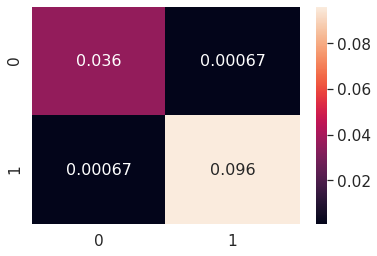

In [0]:
show_results(true_labels, model_predictions, ONLY_CFS = True)

### Embedding Visualization

In [0]:
model_finetuned = fineTunedNet
model_non_finetuned = net

SEED=172

#### Extract Embeddings

We first extract some embeddings (CLS token and embedding of 'sei'). Then build a dataframe with all the collected information (UMAP, TSNE ecc).

In [0]:
finetuned_embs_cls_token=[]
for sentence in df_test['sentence'].values:
  _, emb = embedding_extractor(model_finetuned, sentence, tokenizer, specific_token='<s>', PRINT=False)
  finetuned_embs_cls_token.append(emb)

finetuned_embs_specific_token=[]
for sentence in df_test['sentence'].values:
  _, emb = embedding_extractor(model_finetuned, sentence, tokenizer, specific_token='sei', PRINT=False)
  finetuned_embs_specific_token.append(emb)

# For NON finetuned Model
embs_specific_token=[]
for sentence in df_test['sentence'].values:
  _, emb = embedding_extractor(model_non_finetuned, sentence, tokenizer, specific_token='sei', PRINT=False)
  embs_specific_token.append(emb)

We use UMAP or TSNE to project 768 dimensions (dim of BERT embeddings) down to 2 dimensions.

In [0]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import umap

#--------------------------------------#
SEED = 172
random.seed(SEED)
#--------------------------------------#

# UMAP Proj
reducer = umap.UMAP(random_state = SEED)
# Plotting the average of last layer embeddings
umap_2d_token = reducer.fit_transform([np.array(emb[0]) for emb in embs_specific_token])
# Plotting the first classification token
umap_2d_ft_cls = reducer.fit_transform([np.array(emb[0]) for emb in finetuned_embs_cls_token])
# Plotting the a specific token
umap_2d_ft_token = reducer.fit_transform([np.array(emb[0]) for emb in finetuned_embs_specific_token])

#TSNE Proj
tsne = TSNE(n_components=2, random_state = SEED)
# Plotting the average of last layer embeddings
tsne_2d_token = tsne.fit_transform([np.array(emb[0]) for emb in embs_specific_token])
# Plotting the first classification token
tsne_2d_ft_cls = tsne.fit_transform([np.array(emb[0]) for emb in finetuned_embs_cls_token])
tsne_2d_ft_token = tsne.fit_transform([np.array(emb[0]) for emb in finetuned_embs_specific_token])

In [0]:
# create column with classes as string (for plotting reasons)
dict_label_number = {0: 'class_0', 1: 'class_1', 2: 'class_2'}

df_test['type'] = list(map(lambda x: dict_label_number[x], df_test['label'].values))
df_test['label'].astype(int)

# create column with umap 2d-coordinates for the pretrained gilberto model
df_test['umap_2d_0_token'] = umap_2d_token[:,0]
df_test['umap_2d_1_token'] = umap_2d_token[:,1]

#create column with umap 2d-coordinates for the fine-tuned classification token of gilberto model
df_test['umap_2d_0_ft_cls'] = umap_2d_ft_cls[:,0]
df_test['umap_2d_1_ft_cls'] = umap_2d_ft_cls[:,1]


#create column with umap 2d-coordinates for the fine-tuned specific token of gilberto model
df_test['umap_2d_0_ft_token'] = umap_2d_ft_token[:,0]
df_test['umap_2d_1_ft_token'] = umap_2d_ft_token[:,1]

# create column with tsne 2d-coordinates for the pretrained gilberto model
df_test['tsne_2d_0_token'] = tsne_2d_token[:,0]
df_test['tsne_2d_1_token'] = tsne_2d_token[:,1]

# create column with tsne 2d-coordinates for the fine-tuned classification token of gilberto model
df_test['tsne_2d_0_ft_cls'] = tsne_2d_ft_cls[:,0]
df_test['tsne_2d_1_ft_cls'] = tsne_2d_ft_cls[:,1]

#create column with tsne 2d-coordinates for the fine-tuned specific token of gilberto model
df_test['tsne_2d_0_ft_token'] = tsne_2d_ft_token[:,0]
df_test['tsne_2d_1_ft_token'] = tsne_2d_ft_token[:,1]


In [0]:
df_test.to_csv('./df_sei.tsv', header=False, index=False, sep='\t')
df_test.head(3)

,sentence,label,type,umap_2d_0_token,umap_2d_1_token,umap_2d_0_ft_cls,umap_2d_1_ft_cls,umap_2d_0_ft_token,umap_2d_1_ft_token,tsne_2d_0_token,tsne_2d_1_token,tsne_2d_0_ft_cls,tsne_2d_1_ft_cls,tsne_2d_0_ft_token,tsne_2d_1_ft_token
0,tu sei andata con l altra ragazza a mangiare,1,class_1,-1.141749,1.315518,13.646123,4.548066,13.106608,10.220137,-5.374630,0.537289,-1.139963,8.928967,-6.547016,-5.330422
1,amico mio non sei mai salito piu in alto,1,class_1,0.169604,2.287470,14.615481,4.037889,11.931286,9.727062,-8.416141,-0.780520,2.571413,5.957625,-7.394076,-11.029955
2,momento adatto per colpire ma impiegarono sei ...,0,class_0,20.948631,6.634109,-0.623283,6.748528,-8.908022,-0.844440,14.501611,-18.174429,2.726748,-32.801601,28.822477,10.885617


#### Embedding Visualization

In [0]:
# Choose what to visualize: UMAP, TSNE, BOTH
show_proj = 'BOTH'

# Choose if visualize CLS (alias <\s\>) token embedding or the embedding of "sei"
plot_token_embs = True
plot_cls_embs = not plot_token_embs

In [0]:
from bokeh.plotting import figure, show
from bokeh.layouts import row, column
from bokeh.models import HoverTool, ColumnDataSource 
from bokeh.transform import factor_cmap, factor_mark
from bokeh.io import output_notebook

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

# to use pandas dataframe
source = ColumnDataSource.from_df(df_test) 

# to use some tools form bokeh
tools_to_show = 'box_zoom, save, reset'

# colors and markers for each class
CLASSES= ['class_0', 'class_1']
MARKERS = ['hex', 'triangle']
COLORS = ["#7fc97f", "#f0027f"]

if show_proj == 'UMAP':
  width, height = 700, 570
elif show_proj == 'TSNE':
  width, height = 700, 570
else:
  width, height = 600, 400


# plot title
fig1 = figure(title = "UMAP 2d - proj - Base", tools=tools_to_show, plot_width=width, plot_height=height)
fig2 = figure(title = "UMAP 2d - proj - Fine-Tuned Model", tools=tools_to_show, plot_width=width, plot_height=height)

# define columns to plot
x1, y1 = "umap_2d_0_token", "umap_2d_1_token"
if plot_cls_embs:
  x2, y2 = "umap_2d_0_ft_cls", "umap_2d_1_ft_cls"
elif plot_token_embs:
  x2, y2 = "umap_2d_0_ft_token", "umap_2d_1_ft_token"


fig1.xaxis.axis_label, fig1.yaxis.axis_label = x1, y1
fig2.xaxis.axis_label, fig2.yaxis.axis_label = x2, y2

# hovering tool
fig1.add_tools(HoverTool(tooltips = [("columan_name", "@{sentence}"),])) 
fig2.add_tools(HoverTool(tooltips = [("columan_name", "@{sentence}"),])) 


factor_cmap_col = 'type'

fig1.scatter(x1, y1, source=source, legend_field="label", fill_alpha=0.4, size=12,
          color=factor_cmap(factor_cmap_col, COLORS, CLASSES))
fig2.scatter(x2, y2, source=source, legend_field="label", fill_alpha=0.4, size=12,
          marker="triangle", color=factor_cmap(factor_cmap_col, COLORS, CLASSES))


# plot title
fig3 = figure(title = "TSNE 2d - proj - Base", tools=tools_to_show, plot_width=width, plot_height=height)
fig4 = figure(title = "TSNE 2d - proj - Fine-Tuned Model", tools=tools_to_show, plot_width=width, plot_height=height)

# define columns to plot
x1, y1 = "tsne_2d_0_token", "tsne_2d_1_token"
if plot_cls_embs:
  x2, y2 = "tsne_2d_0_ft_cls", "tsne_2d_1_ft_cls"
elif plot_token_embs:
  x2, y2 = "tsne_2d_0_ft_token", "tsne_2d_1_ft_token"  

    
fig3.xaxis.axis_label, fig1.yaxis.axis_label = x1, y1
fig4.xaxis.axis_label, fig2.yaxis.axis_label = x2, y2

# hovering tool
fig3.add_tools(HoverTool(tooltips = [("columan_name", "@{sentence}"),])) 
fig4.add_tools(HoverTool(tooltips = [("columan_name", "@{sentence}"),])) 

factor_cmap_col = 'type'

fig3.scatter(x1, y1, source=source, legend_field="label", fill_alpha=0.4, size=12,
          color=factor_cmap(factor_cmap_col, COLORS, CLASSES))

fig4.scatter(x2, y2, source=source, legend_field="label", fill_alpha=0.4, size=12,
          marker="triangle", color=factor_cmap(factor_cmap_col, COLORS, CLASSES))


if show_proj == 'UMAP':
  show(row(fig1,fig2))
elif show_proj == 'TSNE':
  show(row(fig3,fig4))
else:
  show(column(row(fig1,fig2), row(fig3,fig4)))



We can easily see that both models (base and finetuned) are able to distinguish the different meanings of the word `sei`. The finetuned model clearly distinguish the two main meaning, being that it was trained to a binary classification task. The base model it is a bit more blurry but this is fine and we can see it is able to distinguish sub clusters of meanings on top of the two main ones (verb and number).  

## Base Model plus K-means for non-labelled data 

We've just seen that to distinguish word meanings the pre-trained (and not finetuned) model already give us pretty good results.

So, suppose now that we collect some sentences (not labelled) that contain the word `secondo` (it has a lot of meanings) and somehow we would like to separate them according to the different meanings of the word.

<center>  <img src="https://drive.google.com/uc?id=1ZHPpPGdDxFR0CkUBo_v0NB67gbPDvaNJ" width="650" height="400">  </center> 



In [0]:
!gdown --id 1-6IeIpZo3meXDm-_d8zbgZAmy6uW99eF

Downloading...
From: https://drive.google.com/uc?id=1-6IeIpZo3meXDm-_d8zbgZAmy6uW99eF
To: /content/poly_secondo.txt
100% 127k/127k [00:00<00:00, 45.4MB/s]


In [0]:
sentences = open('./poly_secondo.txt', 'r')
sentences = [line.strip() for line in sentences.readlines() if 'secondo' in line.split()]

# build up a dataframe
df_test = pd.DataFrame(sentences,columns =['sentence']) 
df_test['sentence'] = sentences
df_test = df_test.dropna()

df_test = df_test.head(500)

In [0]:
!head -n 10 poly_secondo.txt

﻿In PHP per effettuare l’encoding di stringhe secondo il formato JSON si utilizza la funzione json_encode, la quale può produrre solo due possibili valori
Si noti che tutte le informazioni passate alla funzione in esame devono essere codificate secondo il formato UTF-8.
La decodifica di oggetti espressi secondo il formato JON avviene adottando la funzione json_decode. Questa funzione accetta in input solo due informazioni:
Si introdurranno poi le topologie delle reti di calcolatori per capire meglio come gli apparati vengono interconnessi e secondo quali standard.
Le dichiarazioni di Moscovici secondo cui portare il deficit oltre il 3% del Pil "sarebbe un controsenso", questo perché il tetto...
Iscr. e reg. Tribunale di Napoli n. 5208 del 13/4/2001 Responsabile secondo le vigenti norme sulla stampa: Danilo Borsò
2016-09-09 - AVVISO IMPORTANTE - Pubblicazione posti disponibili per Ambito per nomine a T.I. nella scuola media di primo e secondo grado. A.S. 2016/17.
2016-10-18 - RECLUTAMEN

In [0]:
len(df_test)

500

In [0]:
model_non_finetuned = net

In [0]:
embs_specific_token=[]
for sentence in df_test['sentence'].values:
  _, emb = embedding_extractor(model_non_finetuned, sentence, tokenizer, specific_token='secondo', PRINT=False)
  embs_specific_token.append(emb)

In [0]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import umap

#--------------------------------------#
SEED = 172
random.seed(SEED)
#--------------------------------------#

# UMAP Proj
reducer = umap.UMAP(random_state = SEED)
umap_2d_token = reducer.fit_transform([np.array(emb[0]) for emb in embs_specific_token])

#TSNE Proj
tsne = TSNE(n_components=2, random_state = SEED)
tsne_2d_token = tsne.fit_transform([np.array(emb[0]) for emb in embs_specific_token])


#create column with umap 2d-coordinates for the fine-tuned specific token of gilberto model
df_test['umap_2d_0_token'] = umap_2d_token[:,0]
df_test['umap_2d_1_token'] = umap_2d_token[:,1]
df_test['tsne_2d_0_token'] = tsne_2d_token[:,0]
df_test['tsne_2d_1_token'] = tsne_2d_token[:,1]

In [0]:
from sklearn.cluster import KMeans

kmeans_clustering = KMeans( n_clusters = 6 , random_state = SEED)

#idx_embs = kmeans_clustering.fit_predict([np.array(emb[0]) for emb in embs])
idx_umap_2d  = kmeans_clustering.fit_predict(umap_2d_token)

idx_tsne_2d = kmeans_clustering.fit_predict(tsne_2d_token)

df_test['idx_umap_2d'] = idx_umap_2d
df_test['idx_tsne_2d'] = idx_tsne_2d


In [0]:
dict_label_number = {0: 'class_0', 1: 'class_1', 2: 'class_2', 3: 'class_3',  4: 'class_4', 5: 'class_5'}

df_test['idx_umap_2d_str'] = list(map(lambda x: dict_label_number[x], df_test['idx_umap_2d'].values))
df_test['idx_tsne_2d_str'] = list(map(lambda x: dict_label_number[x], df_test['idx_tsne_2d'].values))

In [0]:
from bokeh.plotting import figure, show
from bokeh.layouts import row, column
from bokeh.models import HoverTool, ColumnDataSource 
from bokeh.transform import factor_cmap, factor_mark
from bokeh.io import output_notebook

# Call once to configure Bokeh to display plots inline in the notebook.
output_notebook()

# to use pandas dataframe
source = ColumnDataSource.from_df(df_test) 

# to use some tools form bokeh
tools_to_show = 'box_zoom, save, reset'

# colors and markers for each class
CLASSES= ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5']
#MARKERS = ['hex', 'triangle', 'Cross']
COLORS = ["#7fc97f", "#f0027f", "#ff0000", "#000000", "#0000FF", "#666633"]


width, height = 1100, 700


# plot title
fig1 = figure(title = "UMAP 2d - proj - Gilberto", tools=tools_to_show, plot_width=width, plot_height=height)
fig2 = figure(title = "TSNE 2d - proj - Gilberto", tools=tools_to_show, plot_width=width, plot_height=height)

# define columns to plot
#x0, y0 = "umap_2d_0", "umap_2d_1"
x1, y1 = "umap_2d_0_token", "umap_2d_1_token"
x2, y2 = "tsne_2d_0_token", "tsne_2d_1_token"


fig1.xaxis.axis_label, fig1.yaxis.axis_label = x1, y1
fig2.xaxis.axis_label, fig2.yaxis.axis_label = x2, y2

# hovering tool
fig1.add_tools(HoverTool(tooltips = [("columan_name", "@{sentence}"),])) 
fig2.add_tools(HoverTool(tooltips = [("columan_name", "@{sentence}"),])) 


factor_cmap_col = 'idx_tsne_2d_str'

fig1.scatter(x1, y1, source=source, fill_alpha=0.4, size=12,
          color=factor_cmap(factor_cmap_col, COLORS, CLASSES))
fig2.scatter(x2, y2, source=source, fill_alpha=0.4, size=12,
          marker="triangle", color=factor_cmap(factor_cmap_col, COLORS, CLASSES))


show(column(fig1,fig2))

